##카메라 스티커앱 만들기 첫걸음

개발 환경
<br/>데이터 정보
<br/>Face Bounding Box와 Landmark 검출
<br/>스티커 적용 위치 확인

스티커 적용
<br/>정면 얼굴 사진
<br/>실행 취소 함수
<br/>스티커 부착 함수
<br/>측면 얼굴 사진


결론
<br/>참고문헌

#개발 환경

In [ ]:
import cv2
import dlib
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt

cv2는 openCV(Open Source Computer Vision Library)를 불러온다.
<br/>openCV는 계산 효율성과 실시간 처리에 중점을 둔 컴퓨터 비전 라이브러리이다.
<br/>물체 인식, 얼굴 인식, 제스처 인식, 자율주행 자동차, OCR 판독기, 불량 검사기 등에 활용한다.

dlib는 이미지 처리 및 기계 학습을 하는 c++ 로 개발된 고성능의 라이브러리이다. 얼굴인식에 특화돼있다.

numpy는 array 단위로 벡터와 행렬을 계산한다.

pandas는 행과 열로 이루어진 데이터 객체를 만들어 안정적으로 대용량의 데이터들을 처리한다.

os(Operating System)는 운영체제에서 제공되는 여러 기능을 파이썬에서 수행한다. <br/>예를 들어, 파일 복사, 디렉터리 생성, 파일 목록을 구할 수 있다.

matplotlib은 다양한 데이터와 학습 모델을 시각화한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['pandas=', 'numpy=', 'matplotlib=', 'opencv-python=', 'dlib=']
library_version = []
f = open('/content/drive/MyDrive/lms/library_version.txt', 'r')
line = f.readline()
while True:
    line = f.readline()
    if not line:
      break
    for i in library_name:
      if i in line:
        library_version.append(line)
        library_version.append('    ')

f.close()

import sys
print(sys.version)
print()

for i in range(0, len(library_version) - 1, 6):
  print(str(library_version[i : i+6]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='') 
  if i % 6 == 0:
    print()

for i in range(len(library_version) - 1):
  if (i-1) % 6 == 0 and i == len(library_version) - 6:
    print(str(library_version[-1]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

dlib==19.18.0+zzzcolab20220513001918      matplotlib==3.2.2      numpy==1.21.6     
opencv-python==4.1.2.30      pandas==1.3.5      sklearn-pandas==1.8.0     


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다.

#데이터 정보


[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

Large-scale CelebFaces Attributes (CelebA) Dataset는 202,599명의 유명인사 얼굴 이미지로 구성된다.
<br/>얼굴 인식, 특징 추출, 부위 검출, 편집과 합성 등의 컴퓨터 비전 기술의 데이터셋으로 사용한다.


In [ ]:
list_attr_celeba_path = '/content/drive/MyDrive/LMS/Mustache/list_attr_celeba.csv'
list_attr_celeba = pd.read_csv(list_attr_celeba_path)
list_attr_celeba.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

각 이미지에 대해서 얼굴 특성을 파악하는 40개의 이진 레이블이 있다.

In [ ]:
list_landmarks_align_celeba_path = '/content/drive/MyDrive/LMS/Mustache/list_landmarks_align_celeba.csv'
list_landmarks_align_celeba = pd.read_csv(list_landmarks_align_celeba_path)
list_landmarks_align_celeba.columns

Index(['image_id', 'lefteye_x', 'lefteye_y', 'righteye_x', 'righteye_y',
       'nose_x', 'nose_y', 'leftmouth_x', 'leftmouth_y', 'rightmouth_x',
       'rightmouth_y'],
      dtype='object')

각 이미지에 대해서 얼굴 부위 5개의 레이블이 있다.

[고양이 수염 이미지](https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1)

flaticon 사이트에서 공유하는 저작자 Freepik의 고양이 수염 이미지이다.
<br/>배경이 투명한 확장자 png 파일이다.

#Face Bounding Box와 Landmark 검출

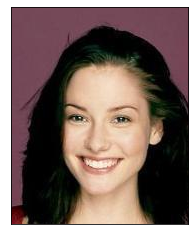

In [ ]:
my_image_path = '/content/drive/MyDrive/LMS/celebA(test)/000961.jpg'
img_bgr = cv2.imread(my_image_path, 1)    
img_show = img_bgr.copy()     
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.yticks([])
plt.xticks([])
plt.show()

celebA(test)는 CelebA에서 10000장만 저장한 데이터셋이다.

OpenCV로 이미지를 불러온다.
<br/>copy()는 출력용 이미지를 따로 보관한다.

Landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾는다.

In [ ]:
detector_hog = dlib.get_frontal_face_detector()

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   

detector_hog를 이용해서 얼굴의 bounding box를 추출한다.

dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환한다.

rectangles[[(32, 80) (139, 187)]]


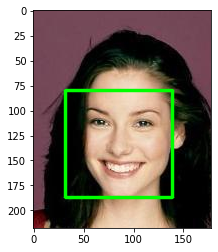

In [ ]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

Object keypoint estimation 알고리즘은 Face landmark와 같이 객체 내부의 점을 찾는 기술이다.
<br/>Bounding Box를 찾고 box 내부의 keypoint를 예측하는 top-down 방식을 따른다.

In [ ]:
model_path = '/content/drive/MyDrive/LMS/Mustache/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [ ]:
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


얼굴 영역의 Bounding Box마다 Face Landmark를 찾아내
<br/>Face Landmark 좌표를 저장한다.

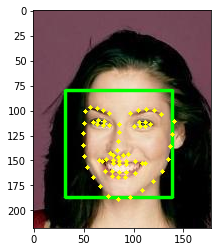

In [ ]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#스티커 적용 위치 확인

[ibug 300-W](https://ibug.doc.ic.ac.uk/)

ibug 300w 데이터셋은 68개를 사용한다.

[Facial point annotations](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations)에서 30은 코의 위치이다.

고양이 수염을 코의 위치에 붙인다.

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) 
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(84, 140)
(x,y) : (84,86)
(w,h) : (108,108)


코의 중심점이 (84, 140)로 나온다.

#스티커 적용

##정면 얼굴 사진

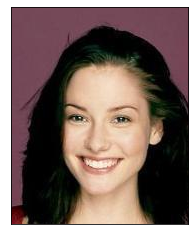

In [ ]:
image_path = '/content/drive/MyDrive/LMS/celebA(test)/000961.jpg'
img = cv2.imread(image_path, 1) 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
plt.yticks([])
plt.xticks([])
plt.show()

In [ ]:
nose_position = list_landmarks_align_celeba[['nose_x','nose_y']]
nose_position[136:137]

,nose_x,nose_y
136,105,136


정면 얼굴 사진의 코의 위치는 (105, 136)이다.

In [ ]:
sticker_path = '/content/drive/MyDrive/LMS/cat mustache.png'
img_sticker = cv2.imread(sticker_path) 
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(108, 108, 3)


고양이 수염 이미지 파일을 불러온다.

In [ ]:
refined_x = x - w // 2
refined_y = y - h // 2
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (30,32)


얼굴 위치, 카메라의 거리에 따라 픽셀 x 가 다르기 때문에 비율로 계산한다.

고양이 수염 스티커가 코의 위치에 정확히 부착될 때까지
<br/>스티커 위치의 수식을 조정한다.

**스티커 위치**

$$ x = x_{nose} - \frac{width}{2}$$

$$y = y_{nose} - \frac{height}{2}$$


**스티커 크기**

$$width = height = width_{bbox}$$

In [ ]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
    
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (30,32)


In [ ]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

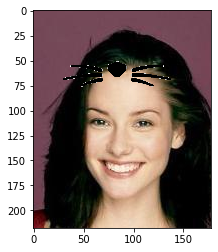

In [ ]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

스티커 위치의 수식에 의해 계산된 코의 위치에 고양이 수염 스티커를 붙이려고 했지만
<br/>엉뚱한 위치인 이마에 스티커가 부착되었다.
<br/>따라서 스티커 위치의 수식을 수정한다.

##실행 취소 함수

In [ ]:
def restore_image(path):
  global img_bgr
  img_bgr = cv2.imread(path, 1)
  img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  plt.imshow(img_bgr)
  plt.yticks([])
  plt.xticks([])
  plt.show()

스티커를 붙이기 전으로 되돌릴 수 있는 의 실행 취소 함수를 정의한다.

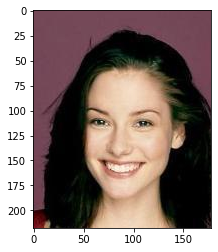

In [ ]:
restore_image(my_image_path)

실행 취소를 하여 스티커를 제거한다.

##스티커 부착 함수

In [ ]:
def stick_image(x_1, x_2, y_1, y_2, img_a):
  list_landmarks = []

  for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

  for landmark in list_landmarks:
    for point in landmark:
      cv2.circle(img_show, point, 2, (0, 255, 255), -1)

  img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

  for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
      print (landmark[30]) 
      x = landmark[30][0]
      y = landmark[30][1] - dlib_rect.height()//2
      w = h = dlib_rect.width()

  sticker_path = '/content/drive/MyDrive/LMS/cat mustache.png'
  img_sticker = cv2.imread(sticker_path) 
  img_sticker = cv2.resize(img_sticker, (w,h))

  refined_x = x - w // x_1 + x_2
  refined_y = y - h // y_1 + y_2

  if refined_x < 0: 
      img_sticker = img_sticker[:, -refined_x:]
      refined_x = 0
  if refined_y < 0:
      img_sticker = img_sticker[-refined_y:, :]
      refined_y = 0

  sticker_area = img_a[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
  img_a[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

  plt.imshow(img_a)
  plt.yticks([])
  plt.xticks([])
  plt.show()

스티커를 붙이는 함수 stick_image를 정의한다.

stick_image에서는 스티커의 위치 수식에서 x_1, x_2, y_1, y_2를 할당한다.
<br/>그리고 이미지 img_a를 할당한다.

**스티커 위치**

$$ x = x_{nose} - \frac{width}{x_1} + x_2$$

$$y = y_{nose} - \frac{height}{y_1} + y_2$$


(84, 140)


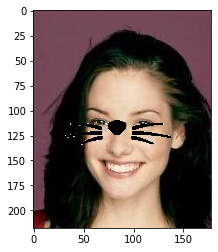

In [ ]:
stick_image(2, 0, 4, 9, img_bgr)

고양이 수염 스티커가 코의 중심이 아닌
<br/>두 눈 사이의 코 맨 위에 붙어있다.

**스티커 위치**

$$ x = x_{nose} - \frac{width}{2} + 0$$

$$y = y_{nose} - \frac{height}{4} + 9$$


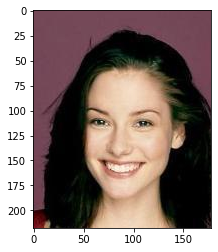

In [ ]:
restore_image(my_image_path)

실행 취소를 하여 스티커를 제거한다.

(84, 140)


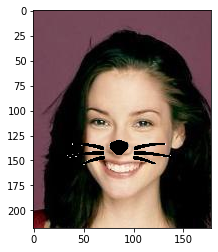

In [ ]:
stick_image(2, 2, 4, 29, img_bgr)

고양이 수염 스티커가 코의 중심에 붙어있다.

**스티커 위치**

$$ x = x_{nose} - \frac{width}{2} + 2$$

$$y = y_{nose} - \frac{height}{4} + 29$$


##측면 얼굴 사진

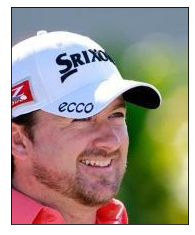

In [ ]:
my_image_path = '/content/drive/MyDrive/LMS/celebA(test)/000137.jpg'
img_bgr = cv2.imread(my_image_path, 1)    
img_show = img_bgr.copy()    
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.yticks([])
plt.xticks([])
plt.show()

In [ ]:
nose_position[137:138]

,nose_x,nose_y
137,89,128


측면 얼굴 사진의 코의 위치는 (89, 128)이다.

In [ ]:
def restore_image(path):
  global img_bgr2
  img_bgr2 = cv2.imread(path, 1)
  img_bgr2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
  plt.imshow(img_bgr2)
  plt.show()

(84, 140)


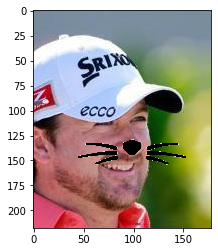

In [ ]:
stick_image(2, 15, 4, 29, img_bgr2)

옆모습 얼굴 사진에는 다른 스티커 위치 수식을 적용해야 한다.

**스티커 위치**

$$ x = x_{nose} - \frac{width}{2} + 15$$

$$y = y_{nose} - \frac{height}{4} + 29$$


#결론

In [ ]:
list_landmarks_align_celeba[['nose_x','nose_y']]

,nose_x,nose_y
0,77,142
1,81,135
2,108,128
3,101,138
4,86,119
...,...,...
202594,89,140
202595,85,141
202596,92,137
202597,90,137


In [ ]:
list_landmarks_align_celeba[['nose_x','nose_y']].max()

nose_x    121
nose_y    156
dtype: int64

In [ ]:
list_landmarks_align_celeba[['nose_x','nose_y']].min()

nose_x    57
nose_y    93
dtype: int64

celebA 데이터셋에 있는 약 20만 개의 이미지에 대해서 얼굴 부위 5개의 레이블이 있다.

레이블 nose_x의 값은 최소값 57부터 최대값 121까지
<br/>nose_y의 값은 최소값 93부터 최대값 156까지 
<br/>이미지마다 코의 위치가 다양하다.

이렇게 되면 이미지가 달라질 때마다
<br/>매번 스티커 위치 수식을 계산하는 번거로운 과정이 필요하다. 
<br/>대신 코의 위치 예측 모델을 적용하는 것이 편리한 방법이다.

그런데 celebA 데이터셋의 모든 이미지의 코의 위치를 레이블에 맞게 예측해서
<br/>고양이 수염 스티커를 붙일 수 있는 모델을 어떻게 만들 수 있는가?

#참고문헌

**LMS Content**
<br/>[tkwoo](https://github.com/tkwoo)

<br/>**공식 사이트**
<br/>[CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)
<br/>[Large-scale CelebFaces Attributes (CelebA) Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

<br/>**웹사이트**
<br/>[Python OpenCV 강좌 : 제 1강 - OpenCV 설치](https://076923.github.io/posts/Python-opencv-1/)
<br/>[Python 얼굴 인식을 위한 라이브러리 설치 ](https://jaura.tistory.com/26)
<br/>[설치된 라이브러리들의 버전 확인 하기](https://sdc-james.gitbook.io/onebook/2./2.1./2.1.5./2)
<br/>[python kernal에 설치된 라이브러리 조회 및 버전 확인하기](https://hengbokhan.tistory.com/30)


